In [1]:
!pip -qq install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.1 MB/s eta 0:00:00:00:0100:01


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

Extracting natural heatmaps: 100%|██████████| 50000/50000 [24:27<00:00, 34.07it/s]


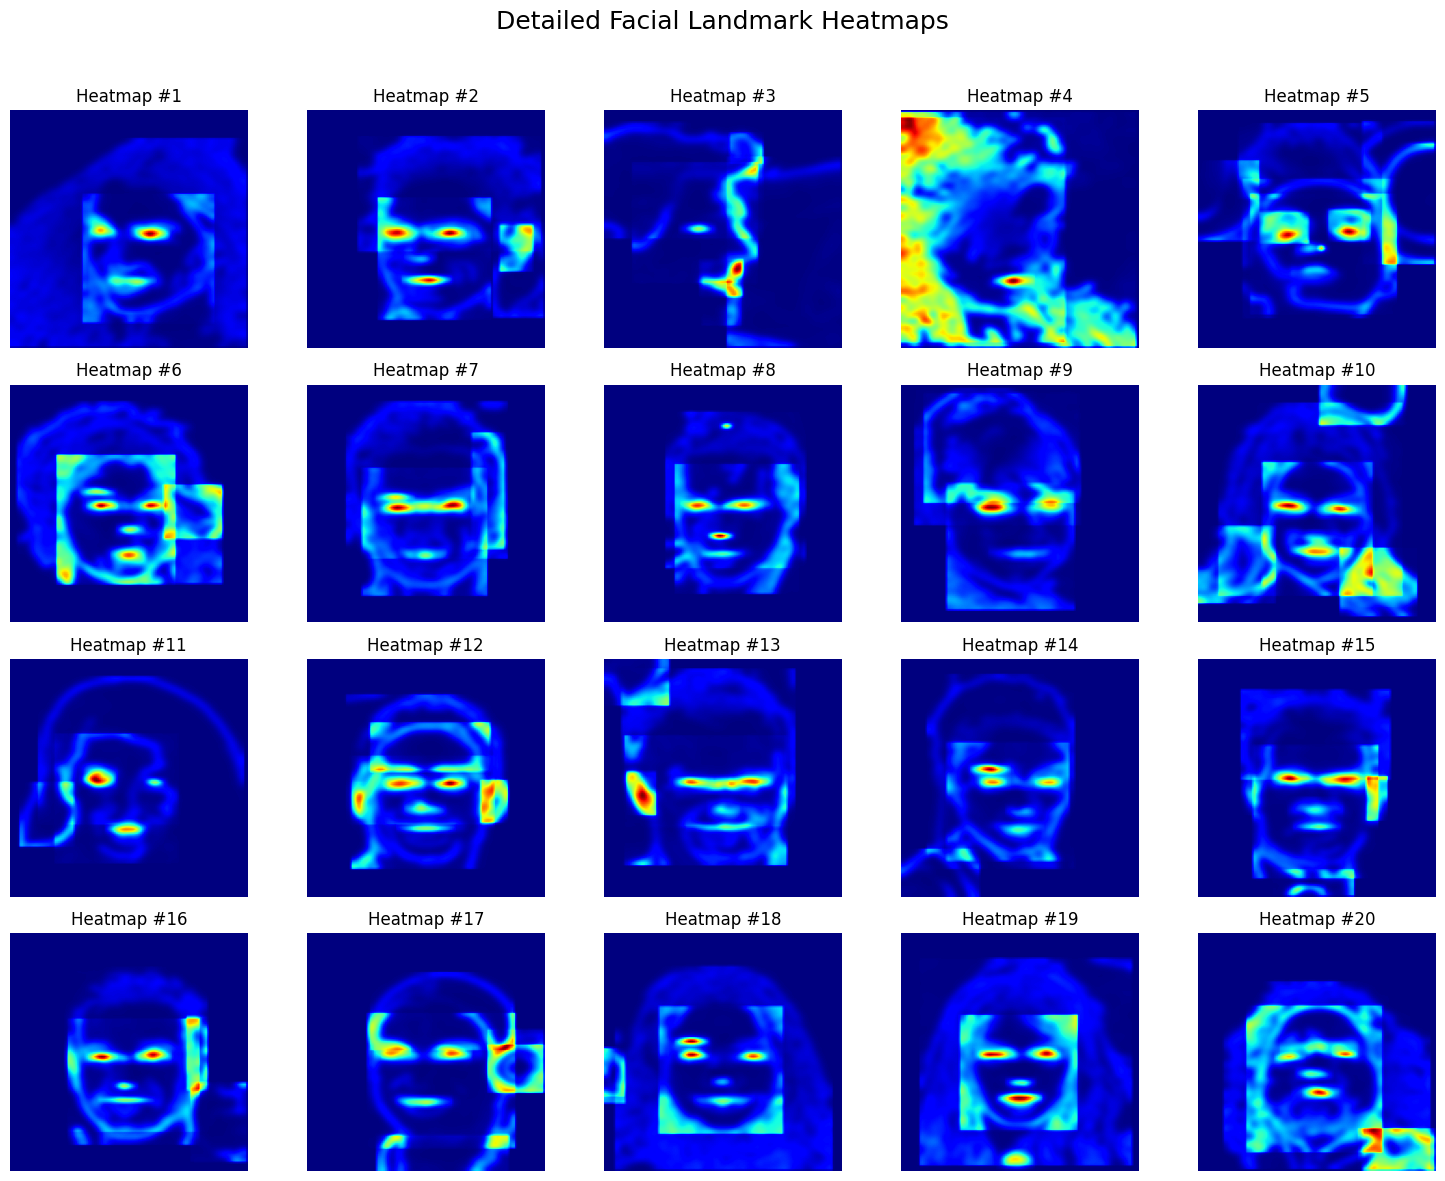

✅ Saved 50000 heatmaps to detailed_heatmaps.h5


In [4]:
# ───────────────────────────────── CONFIG ─────────────────────────────────
INPUT_DIR  = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
MODEL_PATH = "/kaggle/input/yolo-world-small/pytorch/default/1/yolov8s-world.pt"
MASK_H, MASK_W = 128, 128

PROMPTS = ['eye', 'mouth', 'ear', 'nose', 'nosetip', 'face', 'chin', 'head', 'eyebrows']
WEIGHTS = {
    'eye': 4.5, 'mouth': 4.0, 'nose': 4.0, 'nosetip': 3.0,
    'chin': 4.0, 'ear': 4.0, 'eyebrows': 4.0, 'face': 4.0, 'head': 2
}

NUM_IMAGES = 50000  # initial batch to visualize clearly

# ───────────────────────────────── IMPORTS ─────────────────────────────────
import numpy as np, torch, cv2, os, glob
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tqdm import tqdm

# ───────────────────────────────── UTILS ─────────────────────────────────
def inverse_gaussian_fade(shape):
    hh, ww = shape
    y, x = np.meshgrid(np.linspace(-1,1,ww), np.linspace(-1,1,hh))
    distance = np.sqrt(x**2 + y**2)
    sigma = 0.6  # Adjust sigma to control how strong the edges are emphasized
    fade = 1 - np.exp(-(distance**2) / (2 * sigma**2))
    return fade.astype(np.float32)

INV_FADE_CACHE = {}

def get_inverse_fade(shape):
    if shape not in INV_FADE_CACHE:
        INV_FADE_CACHE[shape] = inverse_gaussian_fade(shape)
    return INV_FADE_CACHE[shape]


def extract_edges(img_gray):
    scharr_x = cv2.Scharr(img_gray, cv2.CV_32F, 1, 0)
    scharr_y = cv2.Scharr(img_gray, cv2.CV_32F, 0, 1)
    scharr = np.sqrt(scharr_x**2 + scharr_y**2)
    scharr /= (scharr.max() + 1e-8)

    canny = cv2.Canny(img_gray, 50, 150).astype(np.float32)/255.0

    combined = (0.5 * scharr + 0.5 * canny)
    return combined / (combined.max() + 1e-8)

def gaussian_fade(shape):
    hh, ww = shape
    y, x = np.meshgrid(np.linspace(-1,1,ww), np.linspace(-1,1,hh))
    fade = np.exp(-2.0 * (x**2 + y**2))
    return fade.astype(np.float32)

FADE_CACHE = {}

def get_fade(shape):
    if shape not in FADE_CACHE:
        FADE_CACHE[shape] = gaussian_fade(shape)
    return FADE_CACHE[shape]

def detailed_heatmap(img_rgb, yolo_model, prompts, weights, mask_shape):
    H, W, _ = img_rgb.shape
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    results = yolo_model(img_rgb, conf=0.001, iou=0.1, verbose=False)[0]
    boxes = results.boxes.xyxy.cpu().numpy().astype(int)
    classes = results.boxes.cls.cpu().numpy().astype(int)

    combined_heatmap = np.zeros((H, W), dtype=np.float32)

    for (x1,y1,x2,y2), cls in zip(boxes, classes):
        lab = prompts[cls]
        weight = weights.get(lab, 1.0)

        crop = gray[y1:y2, x1:x2]
        if crop.size==0: continue

        edges = extract_edges(crop)
        edges = cv2.GaussianBlur(edges, (15,15), sigmaX=3)

        # Choose fade type depending on landmark:
        if lab == 'face' or lab == 'head':
            edges *= get_inverse_fade(edges.shape)  # ← inverse Gaussian for face edges
        else:
            edges *= get_fade(edges.shape)          # ← normal Gaussian for other features

        temp_mask = np.zeros((H,W),dtype=np.float32)
        temp_mask[y1:y2,x1:x2] = edges * weight
        combined_heatmap += temp_mask

    combined_heatmap = cv2.GaussianBlur(combined_heatmap, (15,15), sigmaX=0.5)
    combined_heatmap = (combined_heatmap - combined_heatmap.min()) / (combined_heatmap.max() - combined_heatmap.min() + 1e-8)
    return cv2.resize(combined_heatmap, mask_shape)


# ───────────────────────────────── SETUP ─────────────────────────────────
device = 'cuda' if torch.cuda.is_available() else 'cpu'
yolo_model = YOLO(MODEL_PATH).to(device)
yolo_model.set_classes(PROMPTS)
yolo_model.eval()

image_paths = sorted(glob.glob(os.path.join(INPUT_DIR, '*.jpg')))[:NUM_IMAGES]
heatmaps = []

# ───────────────────────────────── GENERATE HEATMAPS ─────────────────────────────────
for path in tqdm(image_paths, desc="Extracting natural heatmaps"):
    img_rgb = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    hm = detailed_heatmap(img_rgb, yolo_model, PROMPTS, WEIGHTS, (MASK_H,MASK_W))
    heatmaps.append(hm)

heatmaps = np.stack(heatmaps)

# ───────────────────────────────── VISUALIZATION ─────────────────────────────────
fig, axes = plt.subplots(4,5, figsize=(15,12))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(heatmaps[i], cmap='jet')
    ax.set_title(f"Heatmap #{i+1}")
    ax.axis('off')
    
plt.suptitle("Detailed Facial Landmark Heatmaps", fontsize=18)
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

import h5py

# ───────────────────────────────── SAVE HEATMAPS TO HDF5 ─────────────────────────────────
with h5py.File('heatmaps.h5', 'w') as hf:
    hf.create_dataset(
        'heatmaps', data=heatmaps.astype('f2'),
        compression='gzip', compression_opts=4
    )

print(f"✅ Saved {len(heatmaps)} heatmaps to heatmaps.h5")


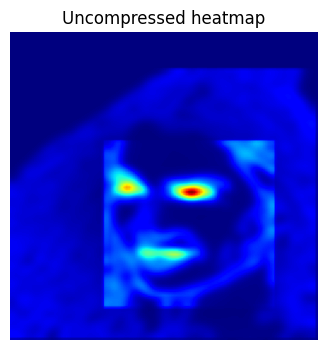

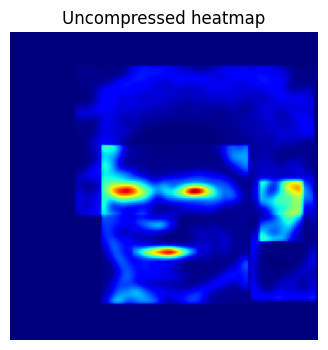

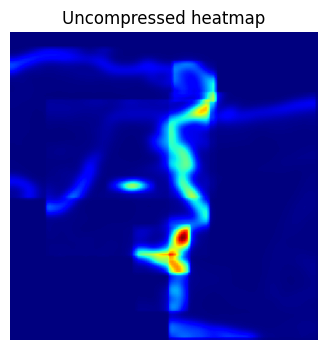

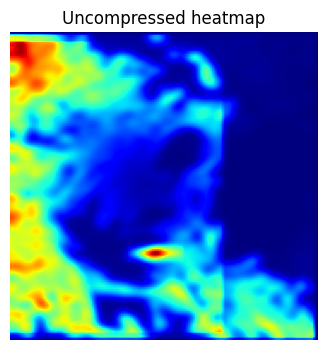

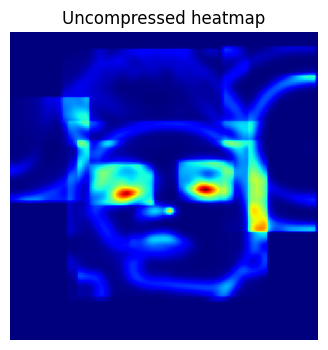

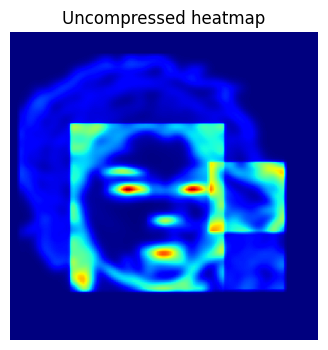

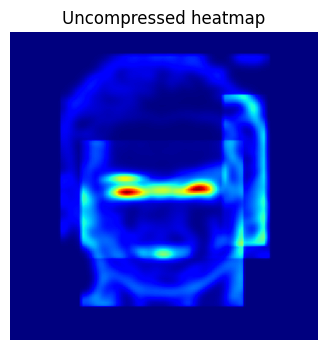

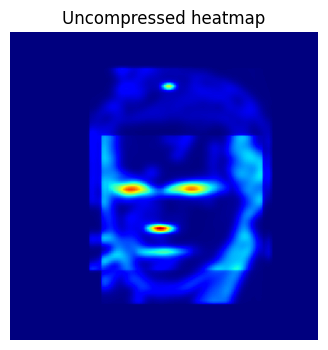

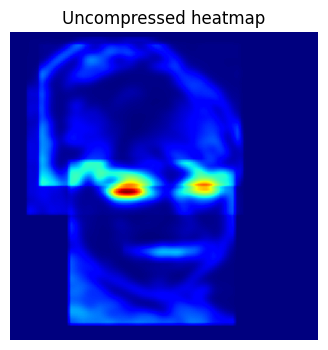

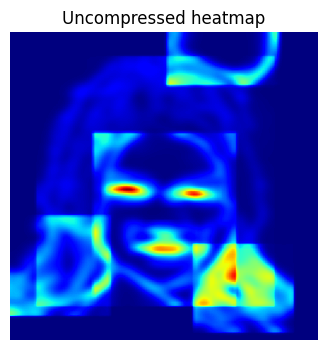

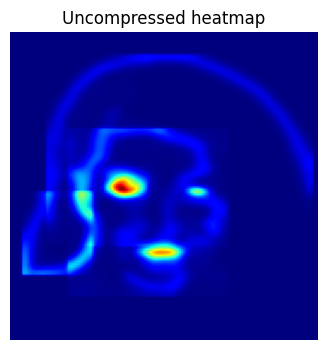

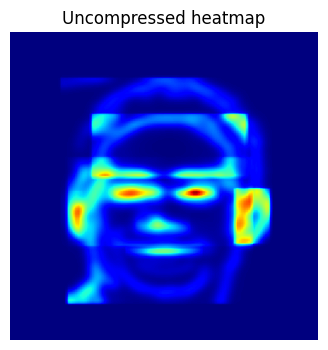

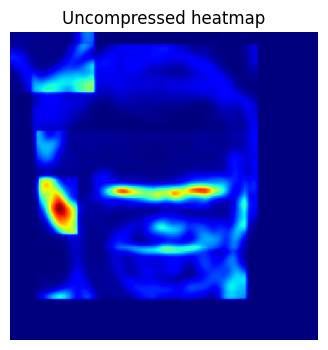

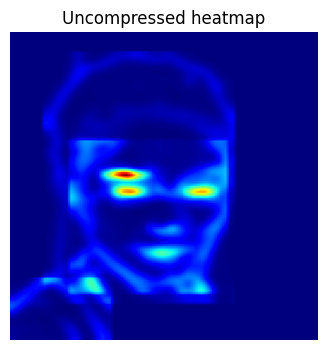

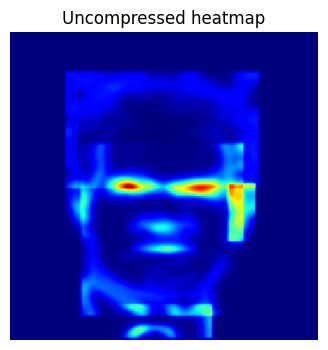

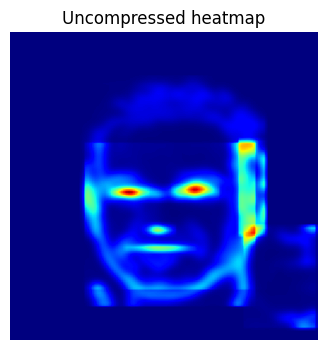

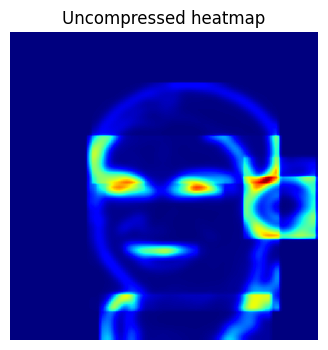

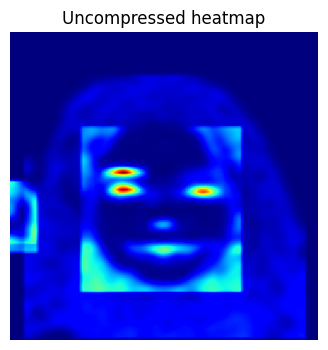

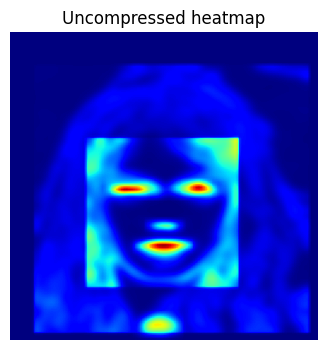

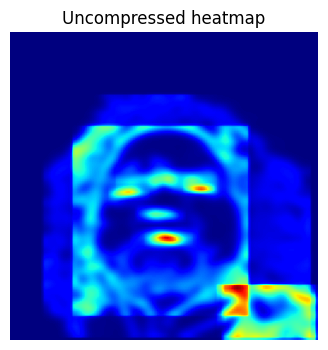

In [5]:
import h5py
import matplotlib.pyplot as plt

h5_path = "/kaggle/working/heatmaps.h5"

for i in range(20):
    with h5py.File(h5_path, 'r') as f:
        heatmaps = f['heatmaps']
        heat = heatmaps[i]
    
    # visualize
    plt.figure(figsize=(4,4))
    plt.imshow(heat, cmap='jet', vmin=0, vmax=1)
    plt.title("Uncompressed heatmap")
    plt.axis('off')
    plt.show()